In [1]:
!pip install icecream


In [2]:
from config import *
import matplotlib 
matplotlib.use('nbagg')
import matplotlib.pyplot as plt


In [23]:
def testinvertrfftfreq():
    "unit test for utility function invertrfftfreq"
    x = np.arange(0, 9, 0.2)
    assert (x == invertrfftfreq(np.fft.rfftfreq(len(x)), 0.2)).all(), f"testinvertrfftfreq failed with x % 2 == {x % 2}"
    x = x[:-1]
    assert (x == invertrfftfreq(np.fft.rfftfreq(len(x)), 0.2)).all(), f"testinvertrfftfreq failed with x % 2 == {x % 2}"

In [6]:
testinvertrfftfreq()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [74]:



x = np.arange(0, 9, 0.2)[:-1]
#print(x, len(x), len(x) % 2)
print(x, len(x))
print(invertrfftfreq(x, 0.2))
#x == invertrfftfreq(np.fft.rfftfreq(len(x)), 0.2)


[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4.  4.2 4.4 4.6 4.8 5.  5.2 5.4 5.6 5.8 6.  6.2 6.4 6.6 6.8 7.
 7.2 7.4 7.6 7.8 8.  8.2 8.4 8.6] 44
even
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4.  4.2 4.4 4.6 4.8 5.  5.2 5.4 5.6 5.8 6.  6.2 6.4 6.6 6.8 7.
 7.2 7.4 7.6 7.8 8.  8.2 8.4 8.6]


In [54]:
np.fft.rfftfreq?

In [29]:
import sys

import numpy as np
import pandas as pd
from icecream import ic

import scipy
from scipy import stats as st
from scipy import optimize as opt

# My packages
sys.path.insert(0, root)

import data_preparation as dp


def load_original_dataset():
    ic()
    file_df_raw = root + "/data/raw/sn_data.parquet"
    df_raw = pd.read_parquet(file_df_raw)
    return df_raw



def preppowerlaw(wvl, flux, cut_vel, c_kms, vel_toosmall, vel_toolarge, 
                                                    plot=False):
    """this function contains functionality for noise extraction in common for the SNID and non SNID case"""
    wvl_ln = np.log(wvl) #log base e
    binsize = wvl_ln[-1] - wvl_ln[-2] #equal bin size in log space

    f_bin, wln_bin = binspec(wvl_ln, flux, min(wvl_ln), max(wvl_ln), binsize) #binned spectrum
    num_bin = len(f_bin) #

    fbin_ft = np.fft.fft(f_bin) #*len(f_bin) # real fft of the binned spectrum
    freq = np.fft.fftfreq(wln_bin.shape[0], binsize) # 1 / ln(wavelength)
    indx = np.arange(1, freq.shape[0] // 2)
    ps = np.abs(fbin_ft[indx]) # magnitude of the power spectrum = sqrt(P)
    
    
    if plot:
        plt.figure(1)
        plt.plot(wvl_ln, flux)
        plt.plot(wln_bin, f_bin, '--')
        plt.title("spectrum")
        plt.show()

        plt.figure(2)
        plt.plot(freq, fbin_ft)
        plt.xlabel("frequency (1/ln(wavelength))")
        plt.yscale('log')
        plt.title("FFT")
        plt.show()   
    
    # Dlambda/lambda = v/c 
    freq_natural_units = freq / c_kms #* binsize
        
    num_upper = np.arange(len(freq))[1.0/freq * c_kms >= vel_toosmall][-1]
    num_lower = np.arange(len(freq))[1.0/freq * c_kms <= vel_toolarge][0]
    mag_avg = np.mean(ps[num_lower:num_upper])
    
    
    #power spectrum in the signal region
    xps = freq[num_lower:num_upper]
    yps = ps[num_lower:num_upper]
    
    finite_mask = np.logical_not(ps==0)
    finite_mask = np.logical_and(finite_mask, np.isfinite(ps))
    if finite_mask.sum() == 0:
        print("no good data points here")
        return None, None, None, None, None, None, None, None, None 
    
    if plot:
        
        plt.figure(3)
        plt.plot(freq[indx], ps)
        plt.axvline(1.0 / (vel_toosmall / c_kms))
        plt.axvline(1.0 / (vel_toolarge / c_kms))
        plt.plot(freq[indx][finite_mask], 
                 ps[finite_mask],  'c--')
        plt.plot(xps, yps, color='r')
        plt.xlabel("frequency (1/ln(wavelength))")
        plt.title("power spectrum")
        plt.yscale('log')
        plt.ylabel("power")
        plt.yscale('log')
        plt.show()  
     
    powerlaw = lambda x, amp, exp: amp * x ** exp
    
    #TODO FBB: these should not be hard coded
    exp_guess = 2 #*slope -hard coded atm
    amp_guess = 800 #np.exp(intercept) hard coded atm
    
    ampfit, expfit = opt.curve_fit(
        powerlaw,
        freq[indx][finite_mask],
        ps[finite_mask], #sigma=np.sqrt(freq[indx][finite_mask]),
        p0=[amp_guess, exp_guess],
    )[0]
    
    if plot:         
        fig = plt.figure(5)
        plt.axvline(1.0 / (vel_toosmall / c_kms))
        plt.axvline(1.0 / (vel_toolarge / c_kms))
        plt.plot(freq[indx][finite_mask],ps[finite_mask]) 
        plt.plot(freq[indx][finite_mask], powerlaw(freq[indx][finite_mask], ampfit, expfit), 'k--')
        plt.xticks(plt.xticks()[0], labels=["%d"%(t * binsize * c_kms) 
                                            for t in plt.xticks()[0]], 
                   rotation=45)       
    #TODO FBB: this should be cleaner - ATM returning everything _and_ the kitchen sink

    return mag_avg, ampfit, expfit, fbin_ft, wln_bin, xps, yps, freq, f_bin

def smooth(wvl, flux, cut_vel, sv=None, plot=False, snidified=False):
    c_kms = 299792.47 # speed of light in km/s
    vel_toosmall = 3_000
    vel_toolarge = 100_000
    
    #common preprocessing for SNID and non SNID spectra
    mag_avg, ampfit, expfit, fbin_ft, wln_bin, xps, yps, freq, f_bin = preppowerlaw(wvl, flux, cut_vel, c_kms,
                                                    vel_toosmall, vel_toolarge, 
                                                    plot=plot)
    if mag_avg == None: return wvl, flux, 0
    
    # find intersection of average fbin_ft magnitude and powerlaw fit to calculate
    # separation velocity between signal and noise.
    intersect_x = np.power((mag_avg / ampfit), 1.0 / expfit)
    sep_vel = 1.0 / intersect_x * c_kms
    
    if sv: 
        sep_vel = sv # allow sv to be passed as a user selected parameter - do that for SNID
    if plot:
        plt.figure(5)
        plt.axvline(intersect_x, color='purple')
        plt.xlabel("velocity")
        
        plt.plot([xps[0], xps[-1]], [mag_avg, mag_avg])
        plt.ylabel("power")
        plt.yscale('log')
        plt.title("power law fit")
        plt.show()

    # filter out frequencies with velocities higher than sep_vel
    smooth_fbin_ft = fbin_ft.copy()
    noise_fbin_ft = fbin_ft.copy()
    ind = np.arange(len(freq))[1.0/freq * c_kms >= sep_vel][-1]

    noise_fbin_ft[:ind] = 0 
    smooth_fbin_ft[ind:] = 0

    smooth_fbin_ft_inv = np.real(np.fft.ifft(smooth_fbin_ft))
    noise_fbin_ft_inv = np.real(np.fft.ifft(noise_fbin_ft))
    
    
    #here is the split between SNIDified and non SNIDified spectra
    if snidified:
        amplitude = lambda y, amp: amp * y
        mask = f_bin != 0
             
        ampfit = opt.curve_fit(
        amplitude,
        smooth_fbin_ft_inv[mask], 
        f_bin[mask], #sigma=np.sqrt(freq[indx][finite_mask]),
        p0=[2],
    )[0]
        smooth_fbin_ft_inv *= ampfit
        smooth_fbin_ft_inv[~mask] = 0
    else:
        from scipy.interpolate import splrep, BSpline
        tck = splrep(wln_bin[:smooth_fbin_ft_inv.shape[0]], 
                 f_bin[:smooth_fbin_ft_inv.shape[0]] - smooth_fbin_ft_inv, s=9)
        smooth_fbin_ft_inv += BSpline(*tck)(wln_bin[:smooth_fbin_ft_inv.shape[0]])
    
    if plot:
        plt.figure(6)
        plt.plot(wln_bin, f_bin, label="orig")
        plt.plot(wln_bin, smooth_fbin_ft_inv, label="inverse")
        if not snidified: 
            plt.plot(wln_bin[:smooth_fbin_ft_inv.shape[0]], 
                     BSpline(*tck)(wln_bin[:smooth_fbin_ft_inv.shape[0]]), label="correction")
        
        
        plt.plot(wln_bin[:smooth_fbin_ft_inv.shape[0]], smooth_fbin_ft_inv, 'k', label="corrected")
        plt.plot(wln_bin[:smooth_fbin_ft_inv.shape[0]], f_bin - noise_fbin_ft_inv, 'r--', 
                 label="f-noise")
        plt.legend()
        plt.show()
      
    w_smoothed = np.exp(wln_bin[:smooth_fbin_ft_inv.shape[0]])
   
    f_smoothed = np.interp(wvl, w_smoothed, smooth_fbin_ft_inv)
    
    return w_smoothed, f_smoothed, sep_vel

def binspec(wvl, flux, wstart, wend, wbin):
    nlam = (wend - wstart) / wbin + 1
    nlam = int(np.ceil(nlam))
    outlam = np.arange(nlam) * wbin + wstart
    answer = np.zeros(nlam)
    interplam = np.unique(np.concatenate((wvl, outlam)))
    interpflux = np.interp(interplam, wvl, flux)

    for i in np.arange(0, nlam - 1):
        cond = np.logical_and(interplam >= outlam[i], interplam <= outlam[i+1])
        w = np.where(cond)
        if len(w) == 2:
            answer[i] = 0.5*(np.sum(interpflux[cond])*wbin)
        else:
            answer[i] = scipy.integrate.simps(interpflux[cond], interplam[cond])

    answer[nlam - 1] = answer[nlam - 2]
    cond = np.logical_or(outlam >= max(wvl), outlam < min(wvl))
    answer[cond] = 0
    return answer/wbin, outlam


def get_noise(wvl, flux, snidified=False, sv=None, plot=False):

        
    cut_vel = 1_000 #km/s - min line velocoty for SN
    #cut_vel_indx = np.argmax(flux)

    w_smoothed, signal, sepv = smooth(wvl, flux, cut_vel, snidified=snidified, sv=sv, plot=plot)    
    noise = flux - signal
    if sepv == 0:
        print("WARNING: failed on this SN")
    
    return noise, w_smoothed, signal




/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:217: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  answer[i] = scipy.integrate.simps(interpflux[cond], interplam[cond])
/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:65: RuntimeWarning: divide by zero encountered in divide
  num_upper = np.arange(len(freq))[1.0/freq * c_kms >= vel_toosmall][-1]
/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:66: RuntimeWarning: divide by zero encountered in divide
  num_lower = np.arange(len(freq))[1.0/freq * c_kms <= vel_toolarge][0]
/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:154: RuntimeWarning: divide by zero encountered in divide
  ind = np.arange(len(freq))[1.0/freq * c_kms >= sep_vel][-1]


<IPython.core.display.Javascript object>


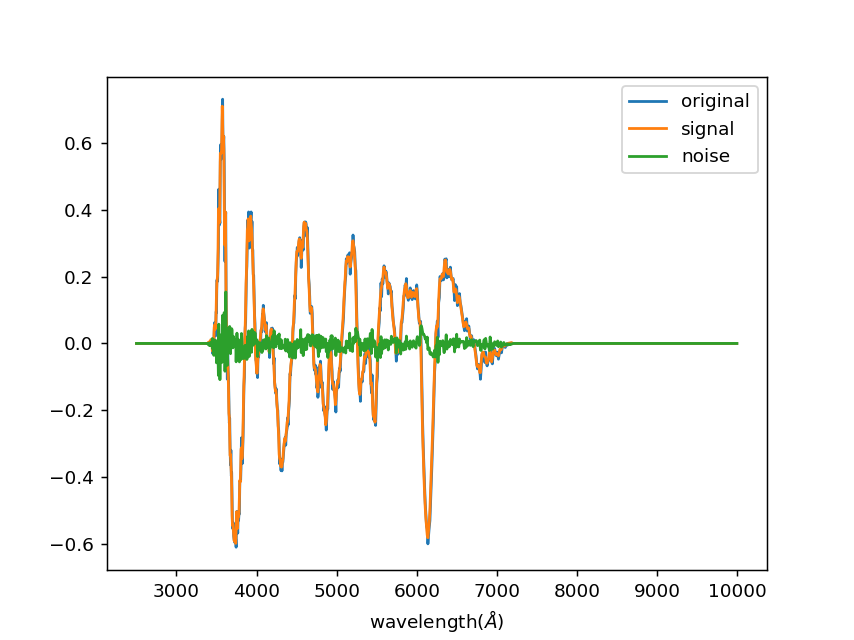

In [912]:
index, wvl, flux_columns, metadata_columns, df_fluxes, df_metadata, fluxes = data
    
noise, wvlnew, signal = get_noise(wvl, fluxes[10], sv=1_000, snidified = True, plot=False)

plt.figure(9)
plt.plot(wvl, fluxes[10], label="original")
plt.plot(wvl, signal, label="signal")
plt.plot(wvl, noise, label="noise")
#plt.plot(wvl, signal - noise)
plt.xlabel(r"wavelength($\AA$)")
plt.legend()
plt.show()


In [914]:

import pandas as pd
df = pd.read_csv("SN.flm", sep='\s+', names=["w", "f"])
wvl = df["w"].values
flux = df["f"].values

/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:217: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  answer[i] = scipy.integrate.simps(interpflux[cond], interplam[cond])


<IPython.core.display.Javascript object>


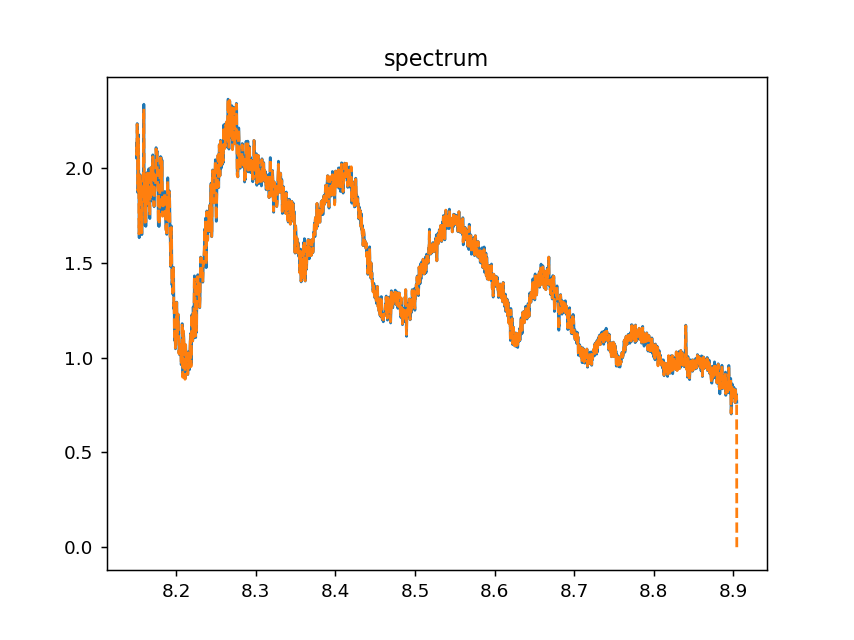

/Users/fbianco/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<IPython.core.display.Javascript object>


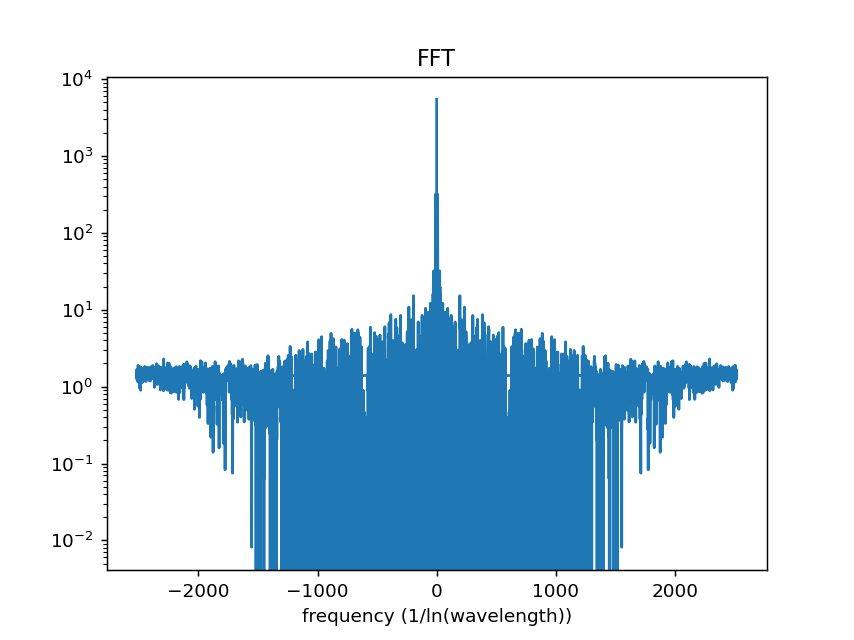

/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:65: RuntimeWarning: divide by zero encountered in divide
  num_upper = np.arange(len(freq))[1.0/freq * c_kms >= vel_toosmall][-1]
/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:66: RuntimeWarning: divide by zero encountered in divide
  num_lower = np.arange(len(freq))[1.0/freq * c_kms <= vel_toolarge][0]


<IPython.core.display.Javascript object>


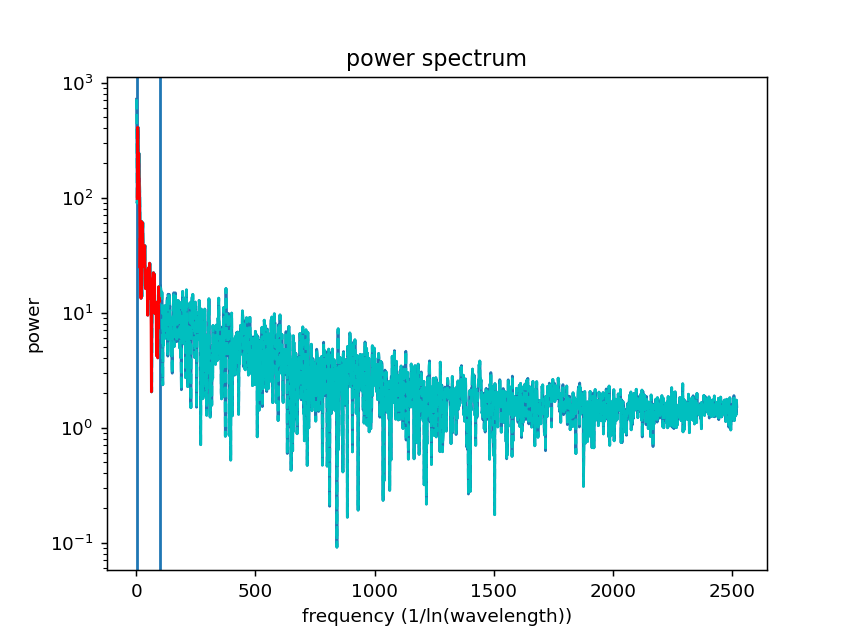

<IPython.core.display.Javascript object>


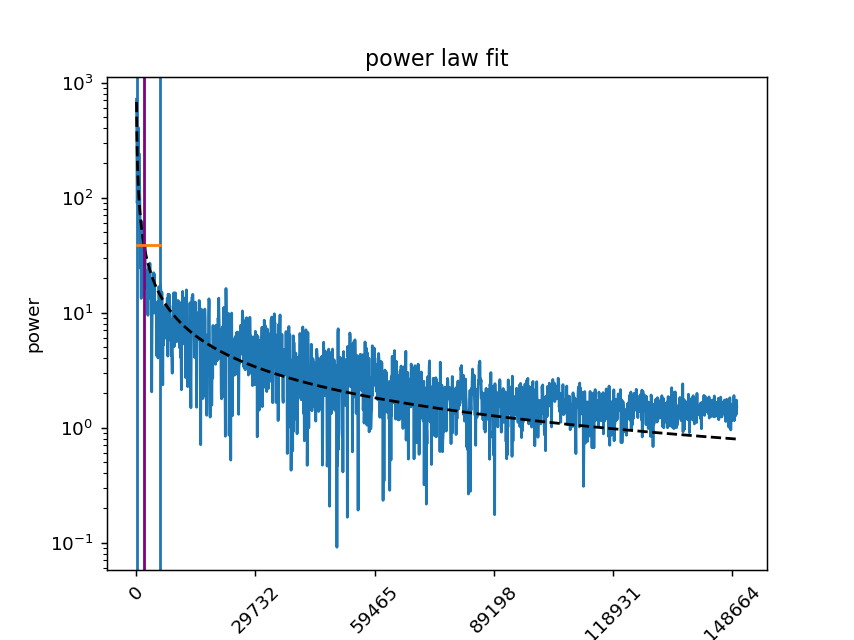

/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:154: RuntimeWarning: divide by zero encountered in divide
  ind = np.arange(len(freq))[1.0/freq * c_kms >= sep_vel][-1]


<IPython.core.display.Javascript object>


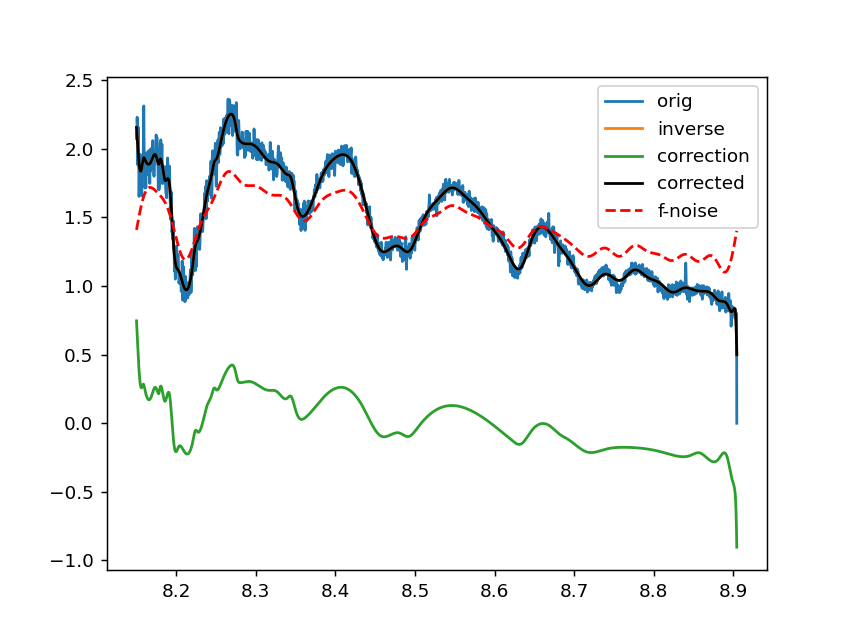

<IPython.core.display.Javascript object>


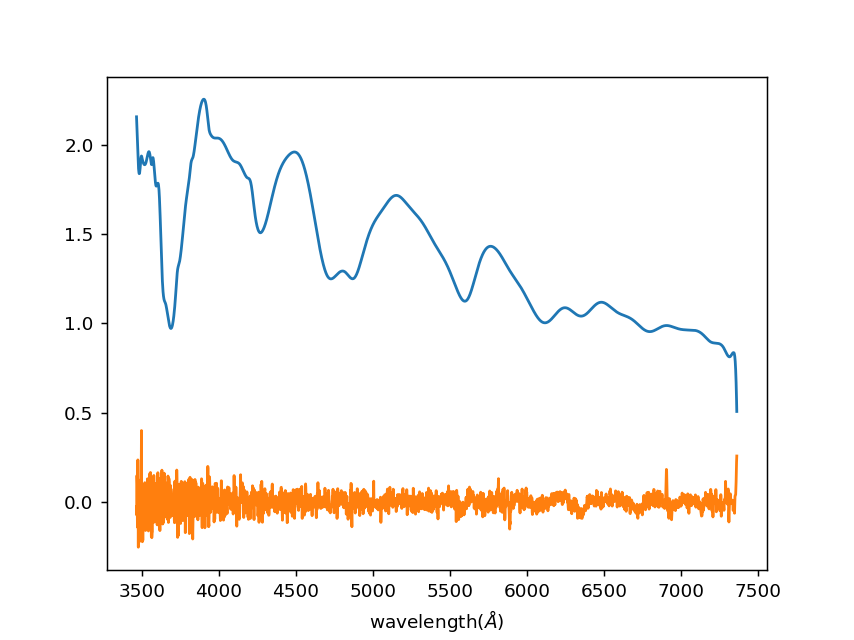

In [915]:
noise, wvlnew, signal = get_noise(wvl, flux, plot=True)
plt.figure(9)
plt.plot(wvl, signal, label="signal")
plt.plot(wvl, noise, label="noise")
#plt.plot(wvl, signal - noise)
plt.xlabel(r"wavelength($\AA$)")
plt.show()


In [917]:
df_raw = load_original_dataset()
    
data = dp.extract_dataframe(df_raw)
    
df_raw

ic| 4047192868.py:18 in load_original_dataset() at 15:24:41.553


,SN Subtype,SN Subtype ID,SN Maintype,SN Maintype ID,Spectral Phase,2501.69,2505.08,2508.48,2511.87,2515.28,...,9872.21,9885.59,9898.98,9912.39,9925.82,9939.27,9952.73,9966.21,9979.71,9993.24
SN Name,,,,,,,,,,,,,,,,,,,,,
sn2008ar,Ia-norm,0,Ia,0,-8.50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2008ar,Ia-norm,0,Ia,0,-7.50,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2008ar,Ia-norm,0,Ia,0,-6.60,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2008ar,Ia-norm,0,Ia,0,-4.60,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2008ar,Ia-norm,0,Ia,0,-3.70,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sn2007uy,Ib-pec,9,Ib,1,12.82,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2007uy,Ib-pec,9,Ib,1,45.82,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sn2007uy,Ib-pec,9,Ib,1,54.82,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [918]:
data[5]


,SN Maintype,SN Maintype ID,SN Subtype,SN Subtype ID,Spectral Phase
SN Name,,,,,
sn2008ar,Ia,0,Ia-norm,0,-8.50
sn2008ar,Ia,0,Ia-norm,0,-7.50
sn2008ar,Ia,0,Ia-norm,0,-6.60
sn2008ar,Ia,0,Ia-norm,0,-4.60
sn2008ar,Ia,0,Ia-norm,0,-3.70
...,...,...,...,...,...
sn2007uy,Ib,1,Ib-pec,9,12.82
sn2007uy,Ib,1,Ib-pec,9,45.82
sn2007uy,Ib,1,Ib-pec,9,54.82


In [919]:
index, wvl, flux_columns, metadata_columns, df_fluxes, df_metadata, fluxes = data
    
vec_get_noise = np.vectorize(get_noise, signature="(n),(n)->(n),(n),(n)")

In [920]:
vec_get_noise

In [921]:
(~(fluxes == df_fluxes.values)).sum()

0

In [922]:
#w_smoothed, signal, _tofit_ = smooth(wvl, fluxes[10], 10_000)

/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:217: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  answer[i] = scipy.integrate.simps(interpflux[cond], interplam[cond])


<IPython.core.display.Javascript object>


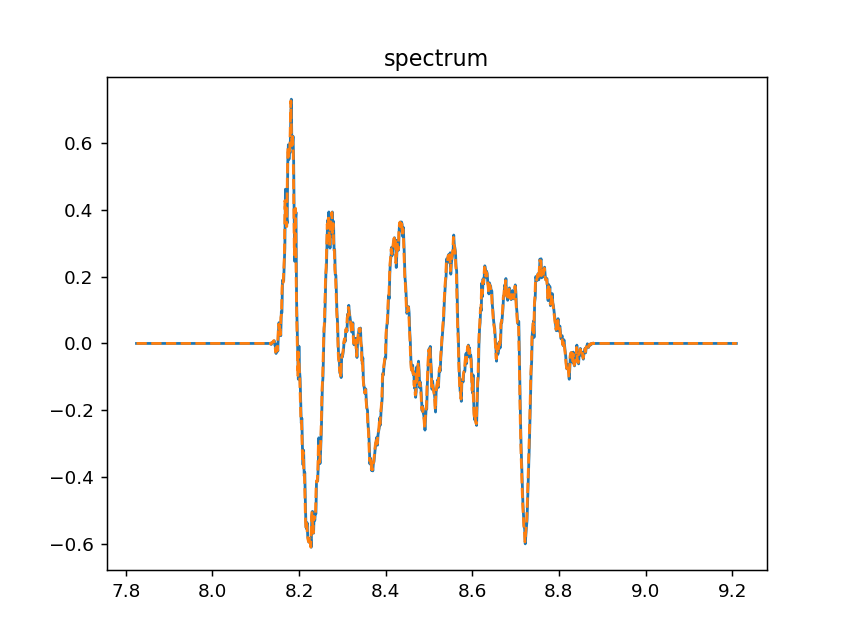

/Users/fbianco/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<IPython.core.display.Javascript object>


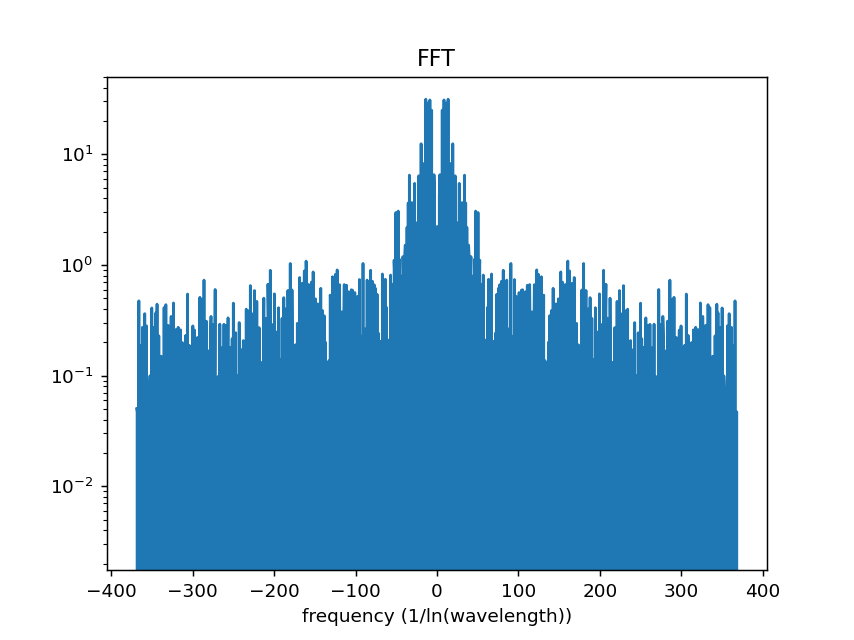

/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:65: RuntimeWarning: divide by zero encountered in divide
  num_upper = np.arange(len(freq))[1.0/freq * c_kms >= vel_toosmall][-1]
/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:66: RuntimeWarning: divide by zero encountered in divide
  num_lower = np.arange(len(freq))[1.0/freq * c_kms <= vel_toolarge][0]


<IPython.core.display.Javascript object>


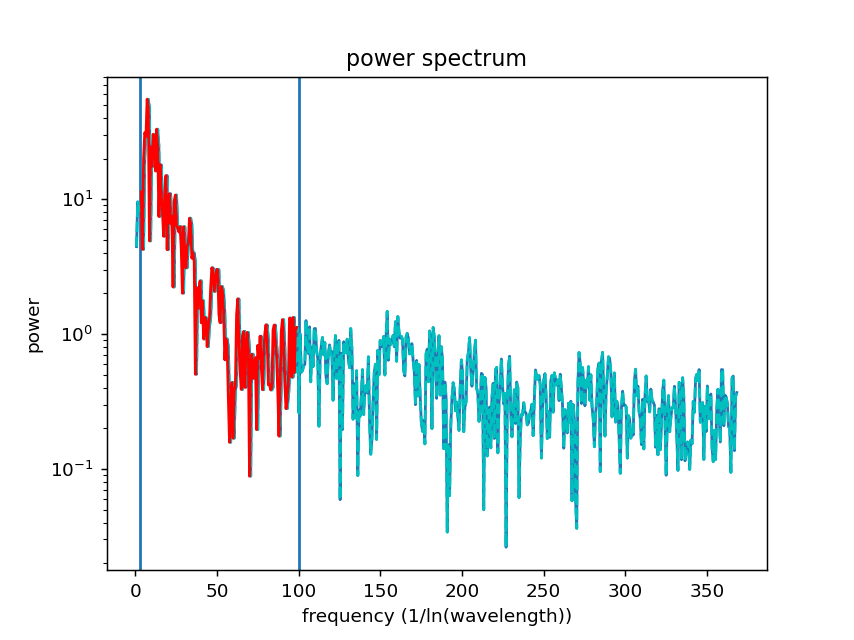

<IPython.core.display.Javascript object>


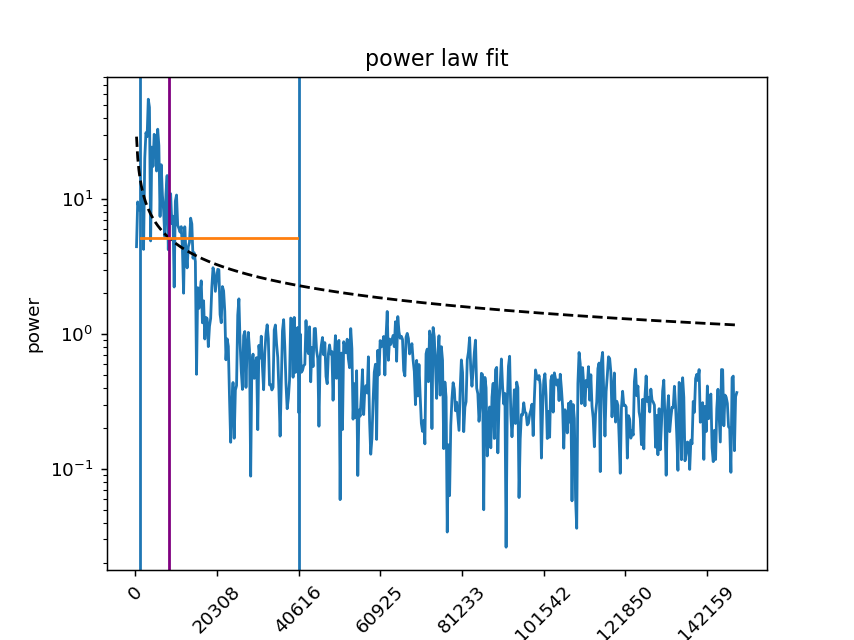

/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:154: RuntimeWarning: divide by zero encountered in divide
  ind = np.arange(len(freq))[1.0/freq * c_kms >= sep_vel][-1]


<IPython.core.display.Javascript object>


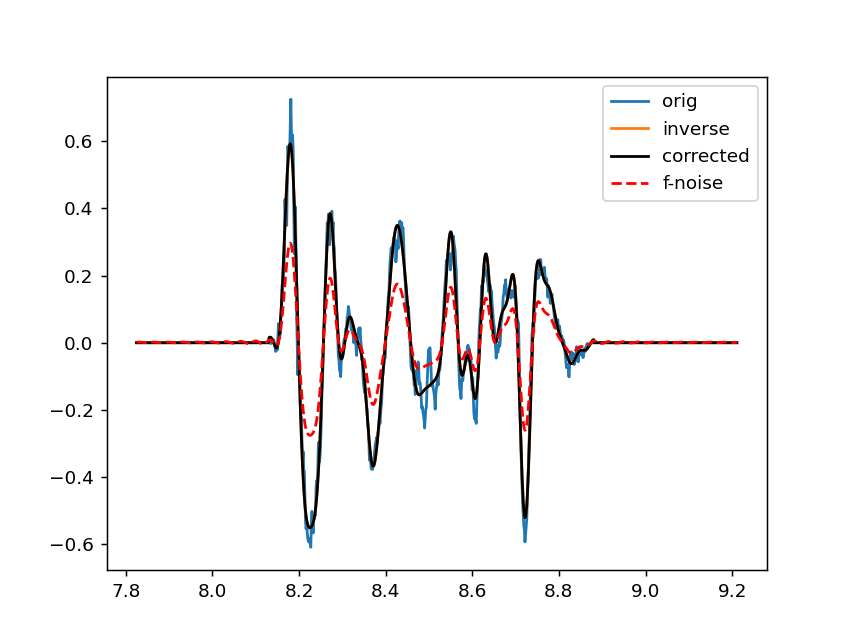

here  [ 2501.69        2505.08166826  2508.47793479 ...  9976.68236346
  9990.20825874 10003.75249176] [0. 0. 0. ... 0. 0. 0.]


<IPython.core.display.Javascript object>


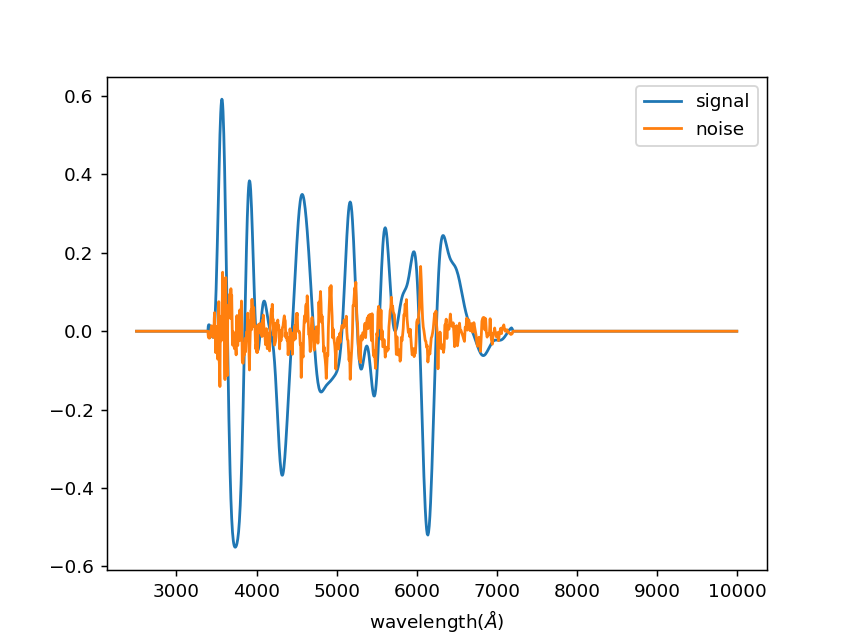

In [923]:
index, wvl, flux_columns, metadata_columns, df_fluxes, df_metadata, fluxes = data
    
noise, wvlnew, signal = get_noise(wvl, fluxes[10], sv=10_000, snidified = True, plot=True)
print("here ", wvlnew, signal)

plt.figure(11)
plt.plot(wvl, signal, label="signal")
plt.plot(wvl, noise, label="noise")
#plt.plot(wvl, signal - noise)
plt.xlabel(r"wavelength($\AA$)")
plt.legend()
plt.show()


In [925]:
print(signal)

[0. 0. 0. ... 0. 0. 0.]


In [926]:
print(wvlnew, signal)

[ 2501.69        2505.08166826  2508.47793479 ...  9976.68236346
  9990.20825874 10003.75249176] [0. 0. 0. ... 0. 0. 0.]


In [927]:
x = np.arange(0, 350)

In [928]:
noise = vec_get_noise(wvl, fluxes)
    

/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:217: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  answer[i] = scipy.integrate.simps(interpflux[cond], interplam[cond])
/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:65: RuntimeWarning: divide by zero encountered in divide
  num_upper = np.arange(len(freq))[1.0/freq * c_kms >= vel_toosmall][-1]
/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:66: RuntimeWarning: divide by zero encountered in divide
  num_lower = np.arange(len(freq))[1.0/freq * c_kms <= vel_toolarge][0]
/var/folders/55/hm2934r523sg5qfprlq_4zkm0000gq/T/ipykernel_99745/4047192868.py:154: RuntimeWarning: divide by zero encountered in divide
  ind = np.arange(len(freq))[1.0/freq * c_kms >= sep_vel][-1]


no good data points here


In [ ]:
df_noise = df_raw.copy(deep=True)
df_noise[flux_columns] = noise
    
df_noise.to_parquet("/home/2649/repos/SCS/data/raw/sn_noise.parquet")